In [1]:
import pathlib
import numpy as np

data_dir = pathlib.Path("/content/drive/MyDrive/Helmet/Train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Class names from subdirectorys
print(class_names)

['With Helmet' 'Without Helmet']


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class

  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}")
  
  return img

['BikesHelmets612.png']
Image shape: (225, 300, 3)


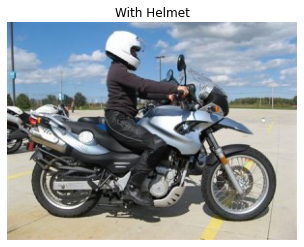

In [3]:
img = view_random_image(target_dir="/content/drive/MyDrive/Helmet/Train/",
                        target_class="With Helmet")

>**Support Functions**

In [4]:
def plot_loss_curve(History): 
  train_loss= History.history["loss"]
  train_accuracy= History.history["accuracy"]

  val_loss= History.history["val_loss"]
  val_accuracy= History.history["val_accuracy"]

  epochs = range(len(History.history["loss"]))

  plt.figure(figsize=(7,7))
  plt.plot(epochs, train_loss, label="train_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.legend()

  plt.figure(figsize=(7,7))
  plt.plot(epochs, train_accuracy, label="train_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.legend()

>**Model**

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.3,
                                             horizontal_flip=True)
test_datagen= ImageDataGenerator(rescale=1/255.)

train_dir = "/content/drive/MyDrive/Helmet/Train"
test_dir = "/content/drive/MyDrive/Helmet/Test"

# augmented
train_data_aug = train_datagen_augmented.flow_from_directory(train_dir,
                                                             target_size= IMG_SIZE,
                                                             batch_size=32,
                                                             class_mode="binary",
                                                             shuffle=False)
# # non_augmented
# train_data_non_aug = train_datagen.flow_from_directory(train_dir,
#                                                        target_size= IMG_SIZE,
#                                                        batch_size=32,
#                                                        class_mode="binary",
#                                                        shuffle=False)

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size= IMG_SIZE,
                                             batch_size=32,
                                             class_mode="binary")

Found 608 images belonging to 2 classes.
Found 153 images belonging to 2 classes.


In [21]:
import tensorflow_hub as hub
from tensorflow.keras import layers

efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"
efficientnet2_url= "https://tfhub.dev/google/efficientnet/b6/classification/1"
mobilenet_url = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"

def create_model(model_url, num_classes=1):

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMG_SIZE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

  return model

In [15]:
"# Create model
efficientnet_model = create_model(efficientnet_url, num_classes= 1)

# Compile
efficientnet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [16]:
# Fit the model
history = efficientnet_model.fit(train_data_aug,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_aug),
                                 validation_data=test_data,
                                 validation_steps=len(test_data),
                                )

Epoch 1/20
19/19 [==============================] - 29s 1s/step - loss: 0.6388 - accuracy: 0.6776 - val_loss: 0.5968 - val_accuracy: 0.7190
Epoch 2/20
19/19 [==============================] - 21s 1s/step - loss: 0.5721 - accuracy: 0.7188 - val_loss: 0.5807 - val_accuracy: 0.6993
Epoch 3/20
19/19 [==============================] - 20s 1s/step - loss: 0.5568 - accuracy: 0.7072 - val_loss: 0.5647 - val_accuracy: 0.6993
Epoch 4/20
19/19 [==============================] - 20s 1s/step - loss: 0.5300 - accuracy: 0.7155 - val_loss: 0.5576 - val_accuracy: 0.7059
Epoch 5/20
19/19 [==============================] - 20s 1s/step - loss: 0.5205 - accuracy: 0.7220 - val_loss: 0.5606 - val_accuracy: 0.6993
Epoch 6/20
19/19 [==============================] - 21s 1s/step - loss: 0.5165 - accuracy: 0.7188 - val_loss: 0.5546 - val_accuracy: 0.7059
Epoch 7/20
19/19 [==============================] - 21s 1s/step - loss: 0.4968 - accuracy: 0.7549 - val_loss: 0.5543 - val_accuracy: 0.7059
Epoch 8/20
19/19 [==

In [24]:
# Create model
efficientnet2_url_model = create_model(efficientnet2_url, num_classes= 1)

# Compile
efficientnet2_url_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [26]:
# Fit the model
history2 = efficientnet2_url_model.fit(train_data_aug,
                                 epochs=10,
                                 steps_per_epoch=len(train_data_aug),
                                 validation_data=test_data,
                                 validation_steps=len(test_data),
                                )

Epoch 1/10
19/19 [==============================] - 41s 1s/step - loss: 0.7920 - accuracy: 0.5526 - val_loss: 0.7184 - val_accuracy: 0.6471
Epoch 2/10
19/19 [==============================] - 24s 1s/step - loss: 0.6181 - accuracy: 0.6990 - val_loss: 0.6749 - val_accuracy: 0.6601
Epoch 3/10
19/19 [==============================] - 24s 1s/step - loss: 0.6097 - accuracy: 0.6776 - val_loss: 0.6351 - val_accuracy: 0.6667
Epoch 4/10
19/19 [==============================] - 24s 1s/step - loss: 0.5426 - accuracy: 0.7155 - val_loss: 0.6297 - val_accuracy: 0.6667
Epoch 5/10
19/19 [==============================] - 24s 1s/step - loss: 0.5661 - accuracy: 0.7171 - val_loss: 0.6670 - val_accuracy: 0.6863
Epoch 6/10
19/19 [==============================] - 24s 1s/step - loss: 0.4991 - accuracy: 0.7516 - val_loss: 0.6168 - val_accuracy: 0.6536
Epoch 7/10
19/19 [==============================] - 24s 1s/step - loss: 0.4631 - accuracy: 0.7599 - val_loss: 0.6186 - val_accuracy: 0.6863
Epoch 8/10
19/19 [==